invalid value encountered in greater_equal



XGBoost Regression Results:
Mean Squared Error (MSE): 0.1699
Root Mean Squared Error (RMSE): 0.4122
Mean Absolute Error (MAE): 0.3710
R² Score: 0.0981
Custom Accuracy (±10% tolerance): 3.08%

[XGBoost] Single User Example:
Original Balance: $3,321.00
Predicted ChargeOffRate: 28.50%
Expected Recovery: $2,374.35

XGBoost Feature Importance (Top 20):
                  Feature  Importance  Importance(%)
Rank                                                
1          PRE-PRNTD CK_Y    0.117913      11.791294
2       ACH EXPTN_PrePaid    0.062353       6.235334
3             ACH REQUEST    0.041740       4.173969
4              FICO SCORE    0.031974       3.197446
5              CONTIN INC    0.030531       3.053089
6     ACH EXPTN_DebitCard    0.025694       2.569396
7             SIGNED_YEAR    0.025397       2.539695
8                     SAC    0.024949       2.494924
9          EMPL_TOTAL_MOS    0.024830       2.483027
10              AMT FINAN    0.024789       2.478868
11         AD

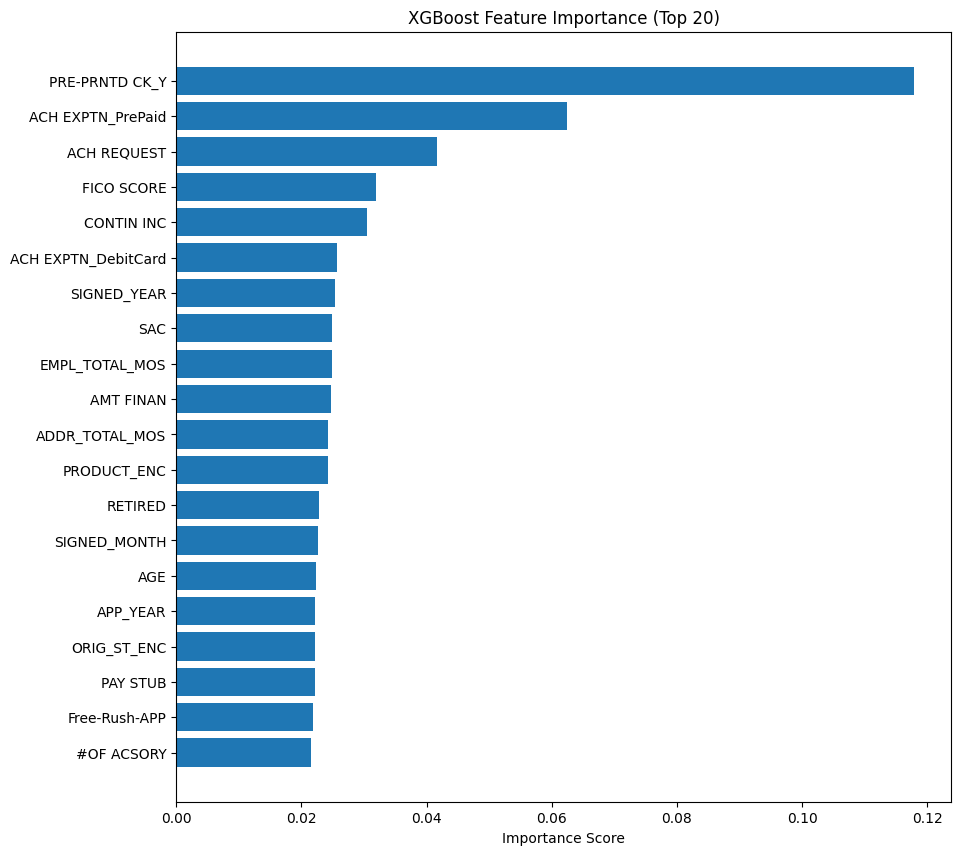

In [1]:
# =========================
# Step 1: Import Libraries
# =========================
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor   # NEW
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# =========================
# Step 2: Load Dataset
# =========================
file_path = "/kaggle/input/trkcus-seasonal-adjustment-dataset-20152020/TRKCUS-01012015-02282020-SST ADJ CORRECTED.xlsx"
df = pd.read_excel(file_path)

# =========================
# Step 3: Feature Engineering (XGBoost version)
# =========================

# With the function of FICO SCORE
df = df[df["FICO SCORE"] != 1].copy()

# 3a. ChargeOffRate
df["ChargeOffRate"] = df["CO AMOUNT"] / df["ORIG BAL"]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ChargeOffRate"])

# Create a new variable where RETIRED = 1 and AGE < 62
df = df[df["ChargeOffRate"] >= 0]   # remove negatives only


df["RETIRED_UNDER62"] = np.where((df["RETIRED"] == 1) & (df["AGE"] < 62), 1, 0)
df["Free-Rush-APP"] = df["PRE-ASSIGNED"].apply(lambda x: "Y" if x in ["C", "L"] else "N")
df["income"] = pd.cut(
    df["INCOM1"],
    bins=[0, 2000, 5000, 10000, float("inf")],
    labels=["Low", "Medium", "High", "Very High"]
)
df["INC-DIS"] = df["I-DIS"]
df["DUR-DIS"] = df["D-DIS"]

# 3b. Dealer Code (first 4 chars)
df["DEALER CODE"] = df["DEALER CODE"].str[:-1].astype(int)
df["PRODUCT"] = df["PRODUCT"].str.strip().str.upper()
df["ORIG ST"] = df["ORIG ST"].str.strip().str.upper()

df["PRODUCT_ENC"] = le.fit_transform(df["PRODUCT"])
df["ORIG_ST_ENC"] = le.fit_transform(df["ORIG ST"])

# 3c. Boolean features: blanks/NaN → N → map to 0/1
binary_cols = [
    "DFRD PMT","SELF EMPL","RETIRED","MILITARY","CB SSN","PAY STUB",
    "RUSH APP","CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP",
    "REFERNCS","SPANISH","#OF ACSORY","INC-DIS","DUR-DIS","RETIRED_UNDER62","Free-Rush-APP"
]
for col in binary_cols:
    df[col] = df[col].fillna("N").replace("", "N").map({"Y": 1, "N": 0})

# 3d. Employment & Address (yrs+mos → total months)
df["EMPL_TOTAL_MOS"] = df["EMPL YRS"].fillna(0) * 12 + df["EMPL MOS"].fillna(0)
df["ADDR_TOTAL_MOS"] = df["ADDR YRS"].fillna(0) * 12 + df["ADDR MOS"].fillna(0)

# 3d(i). Clip outliers in EMPL_TOTAL_MOS and ADDR_TOTAL_MOS
for col, max_cap in [("EMPL_TOTAL_MOS", 600),  # cap at 50 years
                     ("ADDR_TOTAL_MOS", 360)]: # cap at 30 years
    df[col] = df[col].clip(lower=0, upper=max_cap)

# 3e. Dates (APP DATE, SIGNED)
for col in ["APP DATE", "SIGNED"]:
    df[col] = df[col].replace("", np.nan)
    df[col] = pd.to_datetime(df[col], format="%Y%m%d", errors="coerce")

# Make sure APP DATE and SIGNED DATE are datetime
df["APP DATE"] = pd.to_datetime(df["APP DATE"])
df["SIGNED"] = pd.to_datetime(df["SIGNED"])

# Days difference (SIGNED - APP)
df["APP_SIGNED_DAYS"] = (df["SIGNED"] - df["APP DATE"]).dt.days
# Optional: handle invalid or extreme values
df["APP_SIGNED_DAYS"] = df["APP_SIGNED_DAYS"].clip(lower=0)  # no negatives
# Extract date parts
df["APP_YEAR"] = df["APP DATE"].dt.year.fillna(0).astype(int)
df["APP_MONTH"] = df["APP DATE"].dt.month.fillna(0).astype(int)
df["APP_DAYOFWEEK"] = df["APP DATE"].dt.dayofweek.fillna(0).astype(int)

df["SIGNED_YEAR"] = df["SIGNED"].dt.year.fillna(0).astype(int)
df["SIGNED_MONTH"] = df["SIGNED"].dt.month.fillna(0).astype(int)
df["SIGNED_DAYOFWEEK"] = df["SIGNED"].dt.dayofweek.fillna(0).astype(int)

df = df.drop(columns=["APP DATE","SIGNED"])  # drop raw dates

# 3f. SAC (Same-as-Cash promo)
df["SAC"] = pd.to_numeric(df["SAC"], errors="coerce").fillna(0)

# 3g. PRE-ASSIGNED (blanks → N)
df["PRE-ASSIGNED"] = df["PRE-ASSIGNED"].fillna("N").replace("", "N")

# 3h. PRE-PRNTD CK (P → Y, blanks → N)
df["PRE-PRNTD CK"] = df["PRE-PRNTD CK"].replace("P", "Y").fillna("N").replace("", "N")

# 3i. ACH EXPTN (map codes to categories)
ach_map = {
    "C": "CreditCard",
    "D": "DebitCard",
    "N": "NoException",
    "P": "PrePaid",
    "Y": "ACH_Allowed_NoCheck"
}
df["ACH EXPTN"] = df["ACH EXPTN"].map(ach_map).fillna("NoException")

# One-hot encode PRE-ASSIGNED, PRE-PRNTD CK, ACH EXPTN
df = pd.get_dummies(df, columns=["PRE-ASSIGNED","PRE-PRNTD CK","ACH EXPTN"], drop_first=True)

# =========================
# Step 3b: Feature List (same as Linear Regression, but no scaling)
# =========================
features = [
    "FICO SCORE","DEALER CODE","CONTRACT TERM","INT RATE","AMT FINAN","DOWN","DFRD PMT",
    "SELF EMPL","EMPL_TOTAL_MOS","ADDR_TOTAL_MOS","AGE","RETIRED","PRODUCT_ENC","MILITARY","PAY STUB",
    "SAC","RUSH APP","ORIG_ST_ENC","APP_YEAR","APP_MONTH","APP_DAYOFWEEK",
    "CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP","REFERNCS","SPANISH","#OF ACSORY",
    "INC-DIS","DUR-DIS","SIGNED_YEAR","SIGNED_MONTH","SIGNED_DAYOFWEEK","APP_SIGNED_DAYS",
    "PRE-ASSIGNED_Y","PRE-PRNTD CK_Y",
    "ACH EXPTN_CreditCard","ACH EXPTN_DebitCard","ACH EXPTN_PrePaid","ACH EXPTN_ACH_Allowed_NoCheck","RETIRED_UNDER62","Free-Rush-APP","income"
]
features = [col for col in features if col in df.columns]

# Convert features → numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.fillna(0)

# Final dataset
X = df[features]
y = df["ChargeOffRate"]


# =========================
# Step 4: Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# Step 5a: Linear Regression Model
# =========================
# lin_model = LinearRegression()
# lin_model.fit(X_train, y_train)
# y_pred_lin = lin_model.predict(X_test)

# # Evaluate XGBoost
# mse_lin = mean_squared_error(y_test, y_pred_lin)
# r2_lin = r2_score(y_test, y_pred_lin)

# print("Baseline Linear Regression Results:")
# print(f"Mean Squared Error: {mse_lin:.4f}")
# print(f"R^2 Score: {r2_lin:.4f}")

# =========================
# Step 5b: XGBoost Regression Model
# =========================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
# xgb_model = XGBRegressor(
#    n_estimators=500,       # more trees
#     learning_rate=0.05,     # smaller learning rate
#     max_depth=6,            # allow deeper splits
#     subsample=0.8,          # use part of data to avoid overfitting
#     colsample_bytree=0.8,   # use part of features per tree
#     reg_lambda=1,           # L2 regularization
#     reg_alpha=0             # L1 regularization
# )

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)


# Custom "accuracy" (percentage of predictions within ±10% of actual)
tolerance = 0.10
accuracy = np.mean(np.abs((y_pred_xgb - y_test) / y_test) < tolerance) * 100

print("\nXGBoost Regression Results:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Custom Accuracy (±10% tolerance): {accuracy:.2f}%")

# =========================
# Step 6: Predictions for Business Cases
# =========================

# --- Case 1: 50 random users ---
# sample_50 = df.sample(50, random_state=42).copy()
# pred_50_xgb = xgb_model.predict(sample_50[features])

# sample_50["Predicted_ChargeOffRate"] = pred_50_xgb
# sample_50["Expected_Recovery"] = sample_50["ORIG BAL"] * (1 - sample_50["Predicted_ChargeOffRate"])

# Format results nicely
# results_50 = sample_50[["ORIG BAL", "Predicted_ChargeOffRate", "Expected_Recovery"]].copy()
# results_50["ORIG BAL"] = results_50["ORIG BAL"].apply(lambda x: f"${x:,.2f}")
# results_50["Predicted_ChargeOffRate"] = results_50["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")
# results_50["Expected_Recovery"] = results_50["Expected_Recovery"].apply(lambda x: f"${x:,.2f}")

# Display results
# print("\n[XGBoost] Predicted results for 50 users:")
# print(results_50.to_string(index=False))

# Total recovery
# ---- Totals ----
# total_orig_bal = sample_50["ORIG BAL"].sum()
# avg_chargeoff_rate = sample_50["Predicted_ChargeOffRate"].mean()   # average instead of sum
# total_recovery = sample_50["Expected_Recovery"].sum()

# print("\n[XGBoost] Total results for 50 users:")
# print(f"Original Balance: ${total_orig_bal:,.2f}")
# print(f"Predicted ChargeOffRate (avg): {avg_chargeoff_rate:.2%}")
# print(f"Expected Recovery: ${total_recovery:,.2f}")

# --- Case 2: Single user prediction ---
single_user = df.iloc[[0]]  # take first row as example
single_pred_xgb = xgb_model.predict(single_user[features])[0]
single_expected_recovery_xgb = single_user["ORIG BAL"].values[0] * (1 - single_pred_xgb)

print("\n[XGBoost] Single User Example:")
print(f"Original Balance: ${single_user['ORIG BAL'].values[0]:,.2f}")
print(f"Predicted ChargeOffRate: {single_pred_xgb:.2%}")
print(f"Expected Recovery: ${single_expected_recovery_xgb:,.2f}")
# =========================
# Step 7: Feature Importance (XGBoost)
# =========================
xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
})

# Normalize importance (percentage contribution)
xgb_importance["Importance(%)"] = 100 * xgb_importance["Importance"] / xgb_importance["Importance"].sum()

# Sort by importance
xgb_importance = xgb_importance.sort_values("Importance", ascending=False).reset_index(drop=True)

# Add Rank column
xgb_importance.index += 1
xgb_importance.index.name = "Rank"

# Display top features
print("\nXGBoost Feature Importance (Top 20):")
print(xgb_importance.head(20))

# Plot (optional)
plt.figure(figsize=(10, 10))
plt.barh(xgb_importance["Feature"][:20], xgb_importance["Importance"][:20])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance (Top 20)")
plt.gca().invert_yaxis()
plt.show()


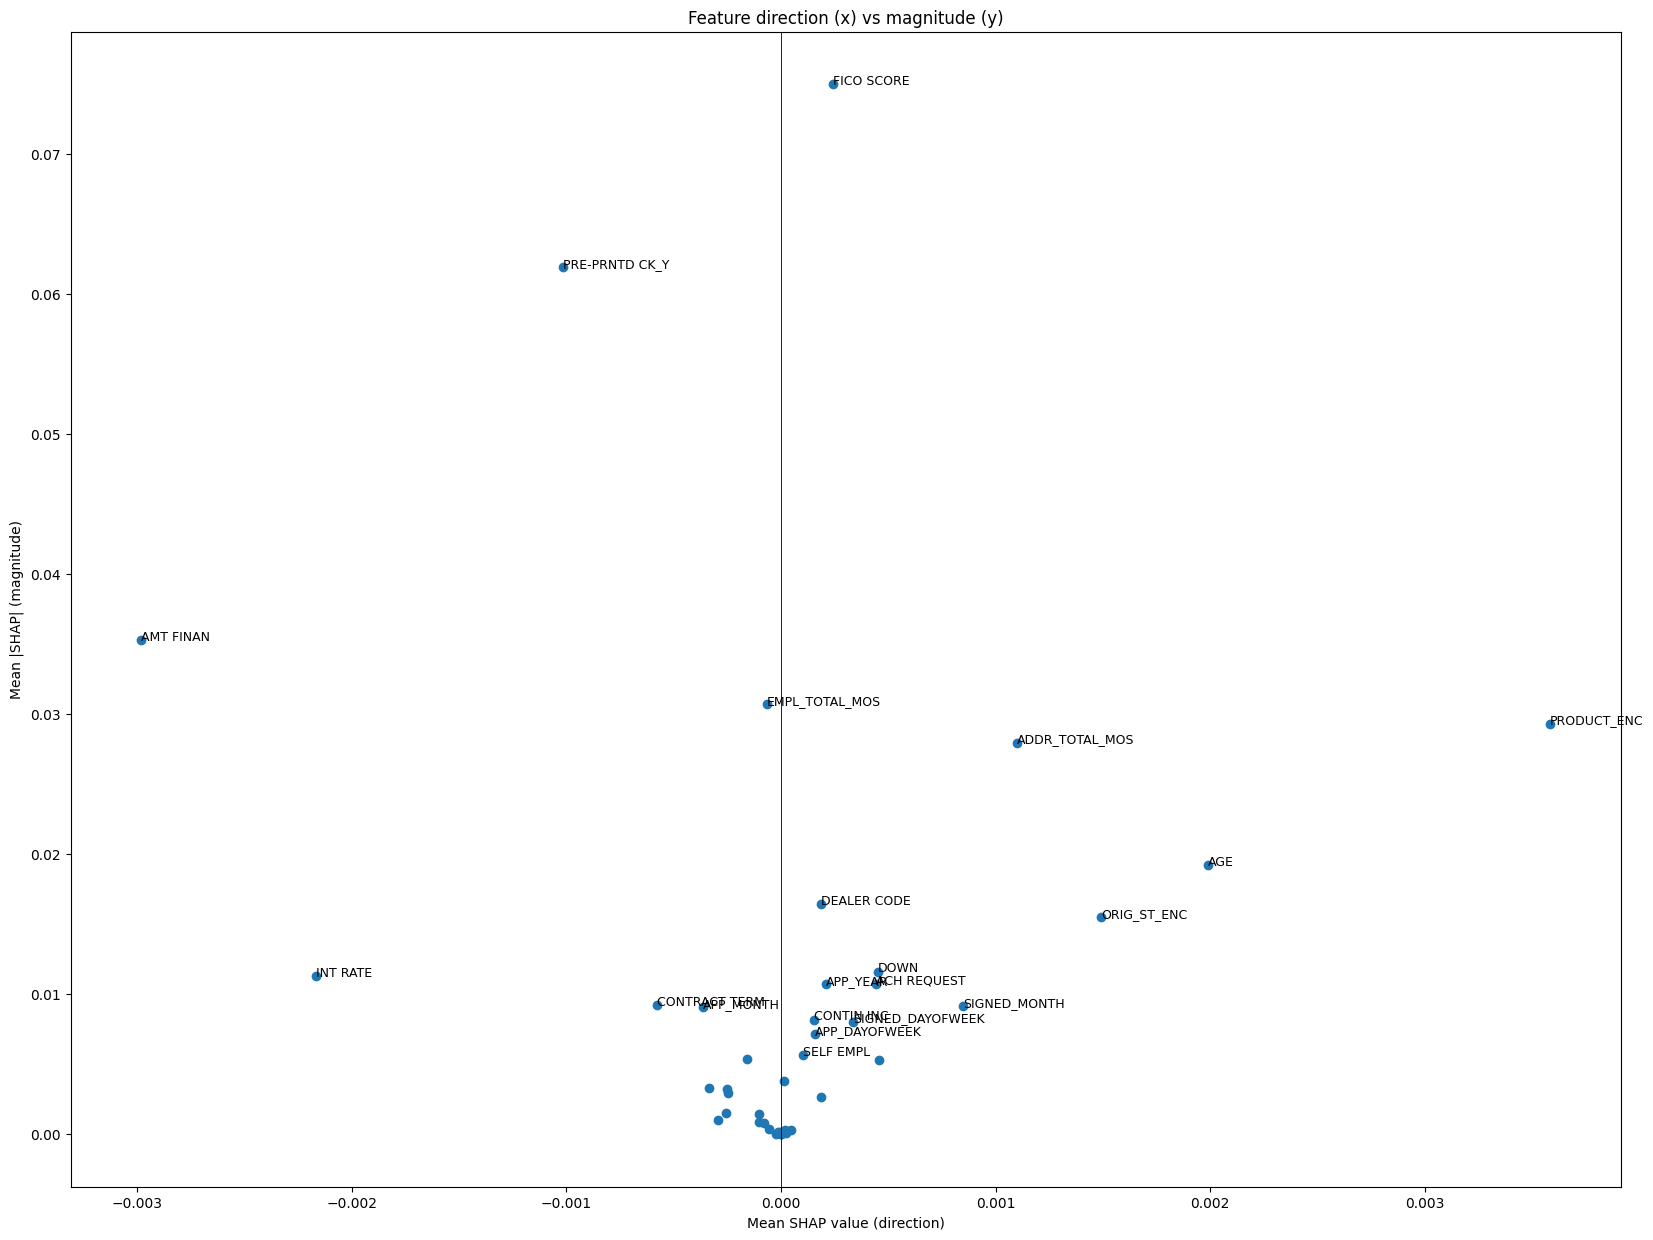

In [2]:
# Ensure numeric data for SHAP
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
X_train = X_train.apply(pd.to_numeric, errors="coerce").fillna(0)
X_test = X_test.apply(pd.to_numeric, errors="coerce").fillna(0)

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_vals = explainer.shap_values(X_test)

# Mean shap values
mean_shap = np.mean(shap_vals, axis=0)
mean_abs_shap = np.mean(np.abs(shap_vals), axis=0)

imp_df = pd.DataFrame({
    "feature": X.columns,
    "mean_shap": mean_shap,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# Plot
plt.figure(figsize=(20,15))  # wider and taller
plt.scatter(imp_df["mean_shap"], imp_df["mean_abs_shap"])
for i,row in imp_df.head(20).iterrows():
    plt.text(row["mean_shap"], row["mean_abs_shap"], row["feature"], fontsize=9)
plt.axvline(0, color='k', linewidth=0.6)
plt.xlabel("Mean SHAP value (direction)")
plt.ylabel("Mean |SHAP| (magnitude)")
plt.title("Feature direction (x) vs magnitude (y)")
plt.show()


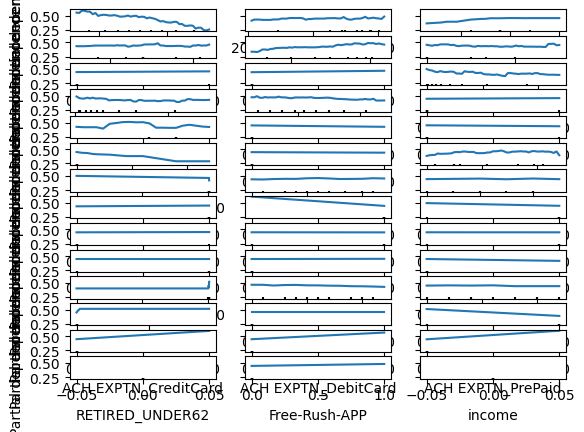

<Figure size 2000x1500 with 0 Axes>

In [3]:
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = features
display = PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_train,
    features_to_plot,
    kind="average",
    grid_resolution=50
)
plt.figure(figsize=(20,15))  # wider and taller

plt.show()

In [4]:
# =========================
# Step 8: Output Predictions on Test Set (XGBoost)
# =========================

# Get indices of test set back to original dataframe
test_results_xgb = df.loc[X_test.index].copy()

# Add actual + predicted
test_results_xgb["Actual_ChargeOffRate"] = y_test
test_results_xgb["Predicted_ChargeOffRate"] = y_pred_xgb  # raw numeric values

# Compute Expected Recovery = ORIG BAL * (1 - Predicted_ChargeOffRate)
test_results_xgb["Expected_Recovery"] = test_results_xgb["ORIG BAL"] * (1 - test_results_xgb["Predicted_ChargeOffRate"])


# Format predictions as percentages
test_results_xgb["Predicted_ChargeOffRate"] = test_results_xgb["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")

# Show first few rows
len(test_results_xgb)

# test_results_xgb.head(10)

# test_results_xgb.shape

4092

In [5]:
# for f in features:
#     shap.dependence_plot(
#         f,
#         shap_vals,
#         X_test,
#         display_features=X_test
#     )
# def binned_effect(df, feature, y_real, y_pred, bins=20):
#     df2 = pd.DataFrame({feature: df[feature], "y": y_real, "yhat": y_pred})
#     df2["bin"] = pd.qcut(df2[feature].rank(method="first"), bins, labels=False)
#     agg = df2.groupby("bin").agg({
#         feature: "median",
#         "y": "mean",
#         "yhat": "mean"
#     }).reset_index()
#     return agg

# # Example: FICO SCORE
# feature = "FICO SCORE"
# agg = binned_effect(X_test, feature, y_test, y_pred_xgb, bins=20)

# plt.plot(agg[feature], agg["y"], label="Actual", marker="o")
# plt.plot(agg[feature], agg["yhat"], label="Predicted", marker="x")
# plt.xlabel(feature); plt.ylabel("ChargeOffRate")
# plt.title(f"Binned Actual vs Predicted: {feature}")
# plt.legend(); plt.show()


Overall R²: 0.0981
R² by SIGNED_YEAR:
 segment
0             NaN
2014    -0.162716
2015     0.140295
2016     0.108760
2017     0.129792
2018     0.050422
2019     0.060000
2020     0.014053
2021   -11.830796
2022          NaN
2023    -0.414968
2024    -0.186346
dtype: float64

R² by FICO SCORE:
 segment
(300, 600]    0.071170
(600, 650]    0.041081
(650, 700]    0.028508
(700, 750]   -0.497937
(750, 850]    0.009990
dtype: float64


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
The default of observed=False is 

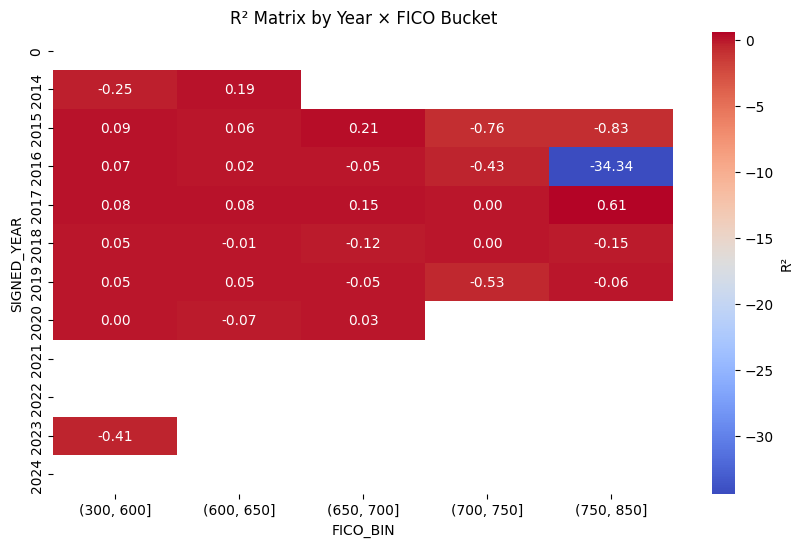

In [6]:
from sklearn.metrics import r2_score

r2_overall = r2_score(y_test, y_pred_xgb)
print("Overall R²:", round(r2_overall, 4))

def r2_by_segment(df, y_true, y_pred, segment_col, bins=None):
    df2 = df.copy()
    df2["y"] = y_true
    df2["yhat"] = y_pred
    
    if bins:  # for continuous features, use bins
        df2["segment"] = pd.cut(df2[segment_col], bins=bins)
    else:
        df2["segment"] = df2[segment_col]
    
    results = df2.groupby("segment").apply(
        lambda g: r2_score(g["y"], g["yhat"]) if len(g) > 1 else None
    )
    return results

# Example 1: by SIGNED_YEAR
r2_by_year = r2_by_segment(X_test, y_test, y_pred_xgb, "SIGNED_YEAR")

# Example 2: by FICO SCORE buckets
fico_bins = [300, 600, 650, 700, 750, 850]
r2_by_fico = r2_by_segment(X_test, y_test, y_pred_xgb, "FICO SCORE", bins=fico_bins)

print("R² by SIGNED_YEAR:\n", r2_by_year)
print("\nR² by FICO SCORE:\n", r2_by_fico)
import seaborn as sns
import matplotlib.pyplot as plt

df_matrix = X_test.copy()
df_matrix["y"] = y_test
df_matrix["yhat"] = y_pred_xgb
df_matrix["FICO_BIN"] = pd.cut(df_matrix["FICO SCORE"], bins=fico_bins)
df_matrix["YEAR"] = df_matrix["SIGNED_YEAR"]

r2_matrix = (
    df_matrix.groupby(["YEAR","FICO_BIN"])
    .apply(lambda g: r2_score(g["y"], g["yhat"]) if len(g)>1 else None)
    .unstack()
)

plt.figure(figsize=(10,6))
sns.heatmap(r2_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label":"R²"})
plt.title("R² Matrix by Year × FICO Bucket")
plt.ylabel("SIGNED_YEAR")
plt.xlabel("FICO_BIN")
plt.show()


In [7]:
test_results_xgb.to_excel("XGBoost-FN-of-FICO_results.xlsx", index=False)

# Move file to working directory so it appears in Kaggle output
import shutil
shutil.move("XGBoost-FN-of-FICO_results.xlsx", "/kaggle/working/XGBoost-FN-of-FICO_results.xlsx")

'/kaggle/working/XGBoost-FN-of-FICO_results.xlsx'